In [1]:
# !pip install scikit-optimize

In [2]:
# import re
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

# forecast
import lightgbm as lgb

# best_cat
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# hyperparameter

from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split, KFold

# Accuracy metric 
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

# warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import zipfile
# with zipfile.ZipFile('/content/data/archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/data/')

In [4]:
df = pd.read_csv('/content/data/Car details v3.csv')

In [5]:
df.shape

(8128, 13)

In [6]:
# plt.figure()
# msno.matrix(df, figsize=(10, 10))

In [7]:
# df.info()

In [8]:
df.dropna(inplace=True)

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)
df_cat = df.drop(columns = df_num.columns, axis=1)

In [10]:
df_cat.head()

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
0,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
1,Skoda Rapid 1.5 TDI Ambition,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm
2,Honda City 2017-2020 EXi,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)"
3,Hyundai i20 Sportz Diesel,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm
4,Maruti Swift VXI BSIII,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)"


In [11]:
df_num['mileage_kmpl'] = df_cat['mileage'].str.extract(r'([0-9.,]+)').astype('float')
df_num['engine_cc'] = df_cat['engine'].str.extract(r'([0-9.,]+)').astype('float')
df_num['max_power_bhp'] = df_cat['max_power'].str.extract(r'([0-9.,]+)').astype('float')

In [12]:
df_num['torque_Nm'] = df_cat['torque'].str.extract(r'([.,0-9]+).*').astype('float')
df_num['torque_rpm_min'] = df_cat['torque'].str.extract(r'[0-9.,].+?[a-zA-Z@].+?([0-9.,]+)').replace(',','', regex=True).astype('float')
df_num['torque_rpm_max'] = df_cat['torque'].str.extract(r'([\d,.]+)(?!.*\d)').replace(',','', regex=True).astype('float')

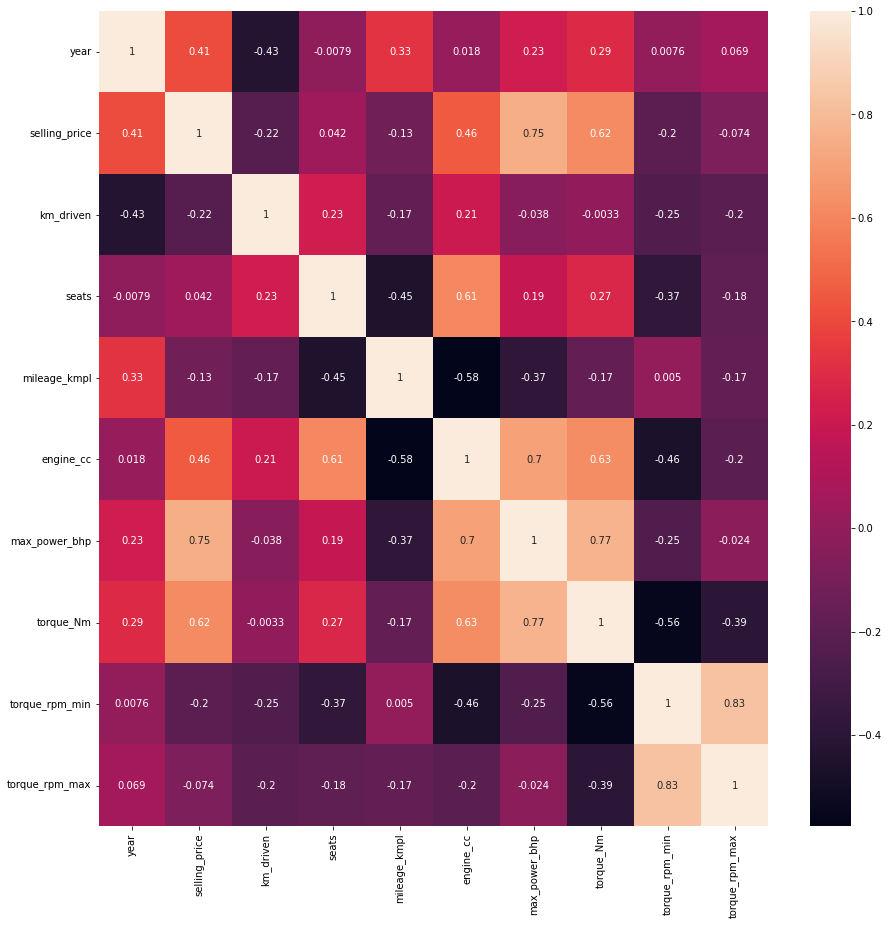

In [13]:
plt.figure(figsize = (15,15))
sns.heatmap(df_num.corr(), annot = True)

In [14]:
# plt.figure()
# sns.pairplot(df_num)

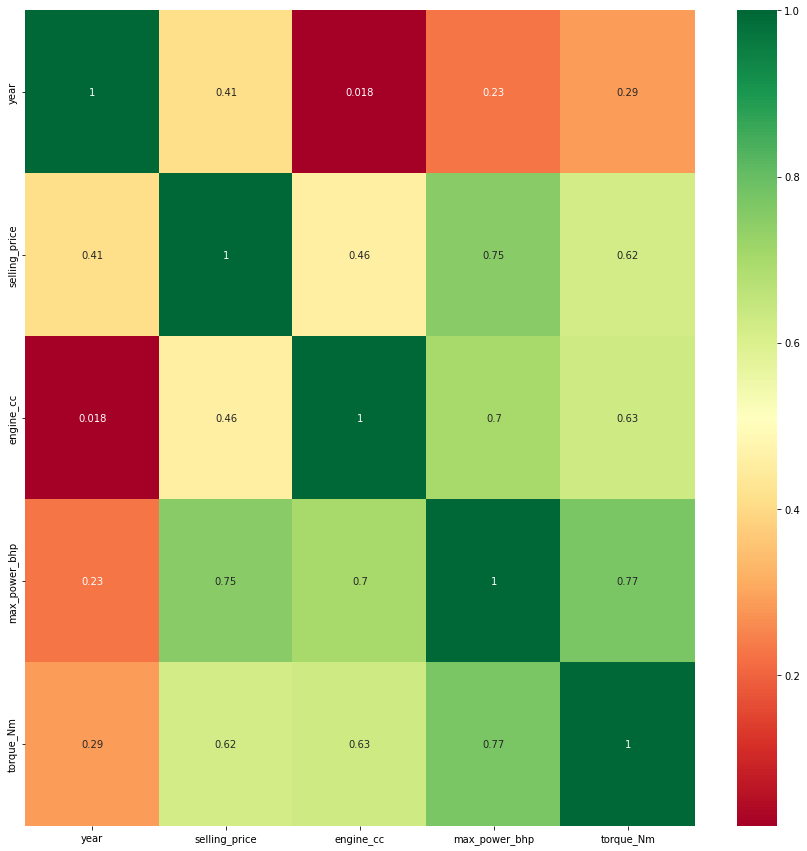

In [15]:
plt.figure(figsize = (15,15))
corr = df_num.corr()

# Ambil fitur dengan korelasi dengan selling_price di atas 0.4
highest_corr_features = corr.index[abs(corr["selling_price"])>0.4]

g = sns.heatmap(df_num[highest_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

In [16]:
df_cat.nunique()

name            1982
fuel               4
seller_type        3
transmission       2
owner              5
mileage          393
engine           121
max_power        320
torque           441
dtype: int64

In [17]:
df_cat = df_cat[['fuel','seller_type', 'transmission', 'owner']]

In [18]:
df_cat = pd.get_dummies(df_cat)

In [19]:
ordered_rank_features = SelectKBest(score_func=chi2, k=14)
ordered_feature = ordered_rank_features.fit(df_cat, df_num['selling_price'])
# ordered_feature.scores_

In [20]:
df_scores = pd.DataFrame(ordered_feature.scores_, columns=['Score'])
df_columns = pd.DataFrame(df_cat.columns)
univariate_ranked = pd.concat([df_columns, df_scores],axis=1)
univariate_ranked.columns = ['Features', 'Scores']
univariate_ranked.set_index('Features', inplace = True)

# Ambil 5 fitur paling penting
top_cat = univariate_ranked.sort_values('Scores', ascending = False).head()

In [21]:
df_new = pd.concat([df_num, df_cat], axis = 1)

In [22]:
df_new.dropna(inplace = True)

In [23]:
lg_search = {
    'max_depth': Integer(1, 10),
    'bagging_freq': Integer(1, 40), 
    'bagging_fraction': Real(0.5, 0.99),
    'n_estimators': Integer(50, 1000),
    'learning_rate': Real(0.0001, 0.1),
    'metric': ['rmse'],
    'boosting_type': Categorical(['dart', 'gbdt', 'rf']), 
    # 'objective': Categorical(['regression_l1', 'regression_l2', 'regression']),
  }

In [24]:
X = df_new[top_cat.index.tolist()+highest_corr_features.tolist()]
y = df_new['selling_price']

In [25]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
# %%time
# model = lgb.LGBMRegressor(objective='regression')
# model.fit(train_x, train_y)

# cv = KFold(n_splits=5)
# opt = BayesSearchCV(model, lg_search, cv=cv)
# opt.fit(train_x, train_y)

In [27]:
# cv_results = pd.DataFrame(opt.cv_results_)
# cv_results.to_csv('params.csv')

In [28]:
lgbm_params = {
  'bagging_fraction': 0.7888367978656703,
  'bagging_freq': 35,
  'boosting_type': 'gbdt',
  'learning_rate': 0.0700085053896429,
  'max_depth': 9,
  'metric': 'rmse',
  'n_estimators': 477,
  'objective': 'regression_l2'}

In [29]:
class Prediction:
  def __init__(self, train_x, test_x, train_y, test_y, val_x, val_y, params):
    self.train_x = train_x
    self.train_y = train_y
    self.test_x = test_x
    self.test_y = test_y
    self.val_x = val_x
    self.val_y = val_y
    self.params = params

  def lgbm(self):
    train = lgb.Dataset(self.train_x, label=self.train_y)
    val = lgb.Dataset(self.val_x, label=self.val_y)
    model  = lgb.train(self.params, train, valid_sets=[val], early_stopping_rounds=50)
    prediction = model.predict(self.test_x)

    return prediction

In [30]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)

In [31]:
predict = Prediction(train_x, test_x, train_y, test_y, val_x, val_y, lgbm_params)

In [32]:
pred = pd.DataFrame(predict.lgbm(), columns=['lgbm'])
# pred['actual'] = test_y

[1]	valid_0's rmse: 708079
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 657399
[3]	valid_0's rmse: 610180
[4]	valid_0's rmse: 566847
[5]	valid_0's rmse: 526372
[6]	valid_0's rmse: 488985
[7]	valid_0's rmse: 454005
[8]	valid_0's rmse: 421285
[9]	valid_0's rmse: 390981
[10]	valid_0's rmse: 362852
[11]	valid_0's rmse: 336875
[12]	valid_0's rmse: 312545
[13]	valid_0's rmse: 290134
[14]	valid_0's rmse: 269079
[15]	valid_0's rmse: 249700
[16]	valid_0's rmse: 231676
[17]	valid_0's rmse: 214744
[18]	valid_0's rmse: 199167
[19]	valid_0's rmse: 184540
[20]	valid_0's rmse: 170947
[21]	valid_0's rmse: 158356
[22]	valid_0's rmse: 146813
[23]	valid_0's rmse: 136028
[24]	valid_0's rmse: 125856
[25]	valid_0's rmse: 116486
[26]	valid_0's rmse: 107770
[27]	valid_0's rmse: 99630.2
[28]	valid_0's rmse: 92261.7
[29]	valid_0's rmse: 85321.4
[30]	valid_0's rmse: 78851.5
[31]	valid_0's rmse: 72950.1
[32]	valid_0's rmse: 67436.3
[33]	valid_0's rmse: 62433.1
[34]	valid_0's r

In [33]:
def acc(y_true, y_pred):
  medae  = median_absolute_error(y_true, y_pred, multioutput='raw_values')
  mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r2 = r2_score(y_true, y_pred)
  return medae, rmse, mae, r2

In [34]:
# pred.lgbm = pred.lgbm.astype('str')
# pred.lgbm = pred.lgbm.str.split('.').str[0]
# pred.lgbm = pd.to_numeric(pred.lgbm, errors='coerce')

In [35]:
pred.lgbm = pd.to_numeric(pred.lgbm, errors='coerce')

In [36]:
pred.describe()

,lgbm
count,1.573000e+03
mean,6.254797e+05
std,7.523902e+05
min,4.715997e+04
25%,2.668558e+05
50%,4.511203e+05
75%,6.743049e+05
max,5.630152e+06


In [37]:
medae, rmse, mae, r2 = acc(test_y, pred.lgbm)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('Test R2: %.8f' % r2)
print('\n')

Test MedAE: 1677.09579425
Test MAE: 4081.24180573
Test RMSE: 19775.38147969
Test R2: 0.99931414




In [42]:
df_new.to_csv("car_sales_detail_forecast.csv")

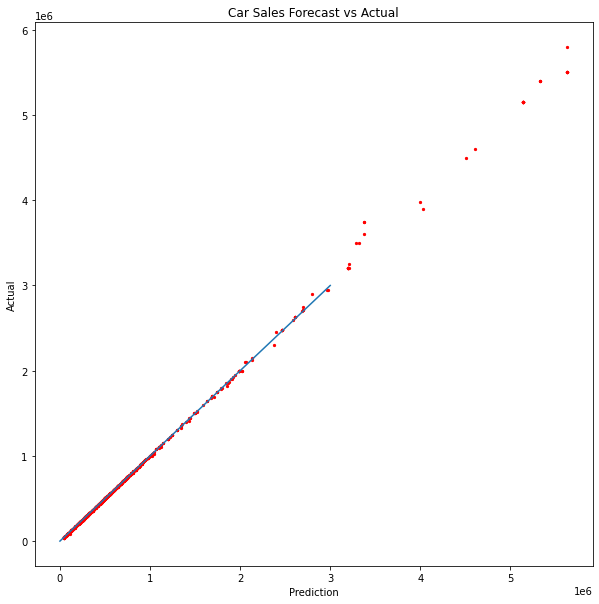

In [40]:
def plot_result(prediction, actual):
  plt.figure(figsize = (10,10))
  plt.scatter(prediction, actual, color = 'r', s = 5)
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.plot([0,3e6], [0,3e6])
  plt.title("Car Sales Forecast vs Actual")
  plt.show()
  
plot_result(pred.lgbm, test_y)